In [1]:
import numpy  as np
import matplotlib.pyplot as plt
import math
import librosa
import os
import pandas as pd
import IPython.display as ipd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, jaccard_score, hamming_loss
import warnings
warnings.filterwarnings("ignore") 

In [2]:
# clone the given repo, to get the model and evaluation metric

!git clone https://github.com/imagecbj/End-to-End-Dual-Branch-Network-Towards-Synthetic-Speech-Detection

Cloning into 'End-to-End-Dual-Branch-Network-Towards-Synthetic-Speech-Detection'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 53 (delta 4), reused 4 (delta 4), pack-reused 43 (from 1)
Receiving objects: 100% (53/53), 335.04 MiB | 40.11 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (42/42), done.


In [3]:
BASE_PATH= '/kaggle/input/asvpoof-2019-dataset/LA/LA'

In [4]:
def dataframe_(df,path):
    df.columns =['speaker_id','filename','null','system_id','class_name']
    df.drop(columns=['null'],inplace=True)
    df['filepath'] = f'{BASE_PATH}/{path}/' + df.filename + '.flac'
    df['target'] = (df.class_name == 'spoof').astype('int32')   # 0 :- Bonafide and 1:- Spoof
    return df

In [5]:
train_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt',
                       sep=" ", header=None)

In [6]:
dev_df = pd.read_csv(f"{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt",
                       sep=" ", header=None)

In [7]:
train_df = dataframe_(train_df,'/ASVspoof2019_LA_train/flac')
dev_df = dataframe_(dev_df,'/ASVspoof2019_LA_dev/flac')

In [8]:
train_df.head()

,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0079,LA_T_1138215,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0
1,LA_0079,LA_T_1271820,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0
2,LA_0079,LA_T_1272637,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0
3,LA_0079,LA_T_1276960,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0
4,LA_0079,LA_T_1341447,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0


In [9]:
dev_df.head()

,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0069,LA_D_1047731,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0
1,LA_0069,LA_D_1105538,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0
2,LA_0069,LA_D_1125976,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0
3,LA_0069,LA_D_1293230,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0
4,LA_0069,LA_D_1340209,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0


**Training Dataset And Validation Dataset Preparation**

**Training Dataset**

In [10]:
train_df.system_id.unique(),dev_df.system_id.unique() 

(array(['-', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06'], dtype=object),
 array(['-', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06'], dtype=object))

In [11]:
train_df.class_name.value_counts()

class_name
spoof       22800
bonafide     2580
Name: count, dtype: int64

In [12]:
train_df_0 = train_df.loc[train_df['class_name']=='bonafide'].reset_index(drop=True)  ## bonafide
train_df_1 = train_df.loc[train_df['class_name']=='spoof'].reset_index(drop=True)     ## spoof

In [13]:
train_df_1.system_id.value_counts()  ### take 430 each (3800//6) 

system_id
A01    3800
A02    3800
A03    3800
A04    3800
A05    3800
A06    3800
Name: count, dtype: int64

In [14]:
train_df_1_filtered = train_df_1.groupby('system_id').head(430).reset_index(drop=True)
train_df_1_shuffled = train_df_1_filtered.sample(frac=1, random_state=42).reset_index(drop=True)

merged_df= pd.concat([train_df_0, train_df_1_shuffled], ignore_index=True)

df = merged_df.sample(frac=1, random_state= 42).reset_index(drop=True)

df.head()

,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0097,LA_T_5322386,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0
1,LA_0079,LA_T_1113976,A04,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,1
2,LA_0084,LA_T_1963829,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0
3,LA_0087,LA_T_5865772,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0
4,LA_0098,LA_T_5312236,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0


In [15]:
df.target.value_counts()

target
0    2580
1    2580
Name: count, dtype: int64

In [16]:
def neg_pos(df):
    neg, pos = np.bincount(df['target'])
    print(f'positive count:{pos} negative count:{neg}')
    total = neg + pos
    print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
        total, pos, 100 * pos / total))


**Validation Dataset :- As I'm just implementing this model, so I will take a small sample of dev_df as a validation set**

In [17]:
dev_df

,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0069,LA_D_1047731,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0
1,LA_0069,LA_D_1105538,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0
2,LA_0069,LA_D_1125976,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0
3,LA_0069,LA_D_1293230,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0
4,LA_0069,LA_D_1340209,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0
...,...,...,...,...,...,...
24839,LA_0078,LA_D_9924204,A06,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,1
24840,LA_0078,LA_D_9931163,A06,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,1
24841,LA_0078,LA_D_9935163,A06,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,1
24842,LA_0078,LA_D_9944718,A06,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,1


In [33]:
# Create bonafide and spoof subsets
dev_df_0 = train_df.loc[train_df['class_name']=='bonafide'].reset_index(drop=True)  # bonafide
dev_df_1 = train_df.loc[train_df['class_name']=='spoof'].reset_index(drop=True)     # spoof

# Take 100 random bonafide samples
dev_df_0_sampled = dev_df_0.sample(n=1008, random_state=42).reset_index(drop=True)

# Take 15 samples per system_id from spoof class
dev_df_1_filtered = dev_df_1.groupby('system_id').head(160).reset_index(drop=True)

# Shuffle the spoof samples
dev_df_1_shuffled = dev_df_1_filtered.sample(frac=1, random_state=42).reset_index(drop=True)

# Merge and shuffle the final dataset
merged_df = pd.concat([dev_df_0_sampled, dev_df_1_shuffled], ignore_index=True)
val_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify counts
print(f"Total samples: {len(val_df)}")
print(f"Bonafide count: {len(val_df[val_df['class_name']=='bonafide'])}")
print(f"Spoof count: {len(val_df[val_df['class_name']=='spoof'])}")
print("Spoof samples per system_id:")
print(val_df[val_df['class_name']=='spoof']['system_id'].value_counts())

val_df.head()

Total samples: 1968
Bonafide count: 1008
Spoof count: 960
Spoof samples per system_id:
system_id
A05    160
A04    160
A06    160
A02    160
A01    160
A03    160
Name: count, dtype: int64


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0084,LA_T_3397728,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0
1,LA_0079,LA_T_2913260,A05,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,1
2,LA_0087,LA_T_7514330,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0
3,LA_0079,LA_T_2742884,A04,spoof,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,1
4,LA_0097,LA_T_2783139,-,bonafide,/kaggle/input/asvpoof-2019-dataset/LA/LA//ASVs...,0


**To view the audio file and its spectrogram**

In [22]:
SAMPLE_RATE = 16000
DURATION = 5.0 # duration in second
AUDIO_LEN = int(SAMPLE_RATE * DURATION)

# Spectrogram params
N_MELS = 128 # freq axis
N_FFT = 2048
SPEC_WIDTH = 256 # time axis
HOP_LEN = AUDIO_LEN//(SPEC_WIDTH - 1) # non-overlap region
FMAX = SAMPLE_RATE//2 # max frequency
SPEC_SHAPE = [SPEC_WIDTH, N_MELS] # output spectrogram shape

In [23]:
def load_audio(filepath, sr=16000):
    audio, sr = librosa.load(filepath, sr=sr)
    return audio, sr

def plot_audio(audio, sr=16000):
    fig = librosa.display.waveshow(audio, axis='time', sr=sr)
    return fig

def listen_audio(audio, sr=16000):
    display(ipd.Audio(audio, rate=sr))
    
def get_spec(audio):
    spec = librosa.feature.melspectrogram(y=audio, fmax=FMAX, n_mels=N_MELS, hop_length=HOP_LEN, n_fft=N_FFT)
    spec = librosa.power_to_db(spec)
    return spec

def plot_spec(spec, sr=16000):
    fig = librosa.display.specshow(spec, x_axis='time', y_axis='hz', hop_length=HOP_LEN, sr=SAMPLE_RATE, fmax=FMAX,)
    return fig

> Filename: LA_T_4050802 | Label: bonafide
# Listen


# Plot



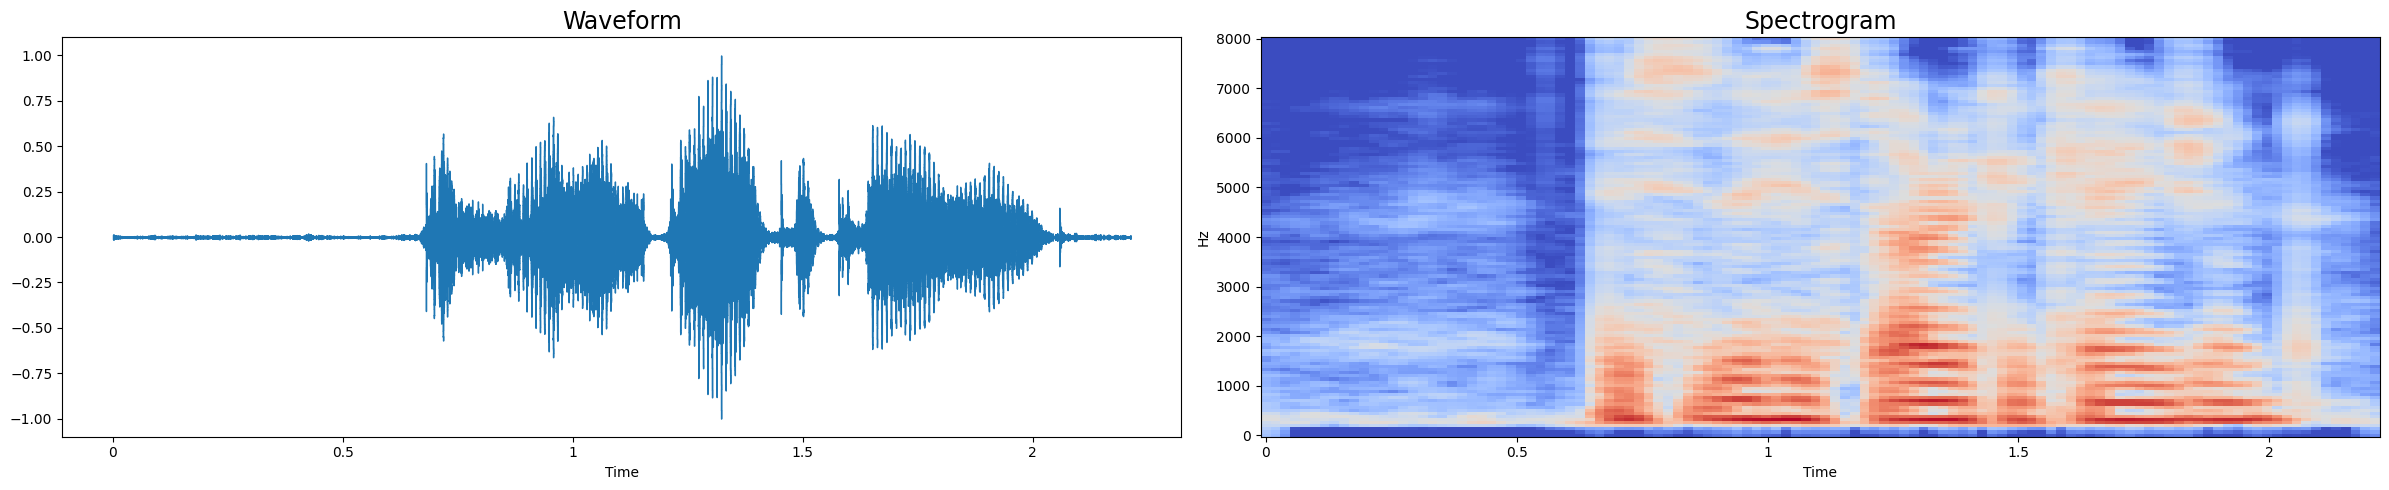

In [24]:
row = df[df.target==0].iloc[10]
print(f'> Filename: {row.filename} | Label: {row.class_name}')
audio, sr= load_audio(row.filepath, sr=None)
audio = audio[:AUDIO_LEN]
spec = get_spec(audio)

print('# Listen')
listen_audio(audio, sr=16000)

print("# Plot\n")
plt.figure(figsize=(12*2,5))

plt.subplot(121)
plot_audio(audio)
plt.title("Waveform",fontsize=17)

plt.subplot(122)
plot_spec(spec);
plt.title("Spectrogram",fontsize=17)

plt.tight_layout()
plt.show()


In [25]:
config = {
    # Data paths
    'access_type': 'LA',
    # Dataset parameters
    'feat_len': 750,
    'padding': 'repeat',
    'enc_dim': 256,
    
    # Training hyperparameters
    'num_epochs': 10,
    'batch_size': 32,
    'lr': 0.0001,
    'beta_1': 0.9,
    'beta_2': 0.999,
    'eps': 1e-8,
    'gpu': '0',
    'num_workers': 0,
    'seed': 688,
    'lambda_': 0.05,
    'weight_decay': 1e-4,
    # Model architecture
    'lfcc_dim': 60,  # 60-dimensional LFCC
    'cqt_dim': 100,  # 100-dimensional CQT
    'n_classes': 2,  # bonafide vs spoof
    'n_types': 6,   # A01-A06 attack types
    'best_f1': 0.98
}

In [26]:
# split the dataset into train, val and test

neg_pos(df)

print("*"*50)

neg_pos(val_df)

positive count:2580 negative count:2580
Examples:
    Total: 5160
    Positive: 2580 (50.00% of total)

**************************************************
positive count:1500 negative count:1548
Examples:
    Total: 3048
    Positive: 1500 (49.21% of total)



**Dataloader and Model**

In [34]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T
import numpy as np
from scipy import signal
import soundfile as sf
import librosa

import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Function
import random
import torch.optim as optim


sys.path.append('/kaggle/working/End-to-End-Dual-Branch-Network-Towards-Synthetic-Speech-Detection')
import eval_metrics as em

In [35]:
class AudioFeatureDataset(Dataset):
    def __init__(self, dataframe, labels=None, sample_rate=16000,
                 # LFCC parameters
                 n_lfcc=20, lfcc_n_filter=40, lfcc_hop_length=160, lfcc_win_length=320,
                 # CQT parameters
                 cqt_hop_length=512, n_cqt_bins=100, cqt_bins_per_octave=12,
                 cqt_fmin=3.5, pre_emphasis=0.97, top_db=None,
                 feat_len=750, padding='repeat',
                test=True):
        
        self.dataframe = dataframe
        self.labels = labels if labels is not None else dataframe['target'].values
        self.sample_rate = sample_rate
        self.feat_len = feat_len
        self.padding = padding
        self.pre_emphasis = pre_emphasis
        
        # LFCC transform (MATLAB compatible)
        self.lfcc_transform = T.LFCC(
            sample_rate=sample_rate,
            n_filter=lfcc_n_filter,
            n_lfcc=n_lfcc,
            log_lf=True,  # Includes pre-emphasis
            speckwargs={
                'n_fft': 512,
                'hop_length': lfcc_hop_length,
                'win_length': lfcc_win_length,
                'window_fn': torch.hamming_window,
                'power': 2.0,
                'center': False  # Matches MATLAB's buffer()
            }
        )
        
        # Delta computation
        self.compute_deltas = T.ComputeDeltas(win_length=9)  # MATLAB uses 9-point window
        
        # CQT parameters
        self.cqt_params = {
            'sr': sample_rate,
            'hop_length': cqt_hop_length,
            'n_bins': n_cqt_bins,
            'bins_per_octave': cqt_bins_per_octave,
            'window': 'hann',
            'fmin': cqt_fmin,
            'top_db': top_db
        }
        
        # Attack type to label mapping
        self.tag = {
            "-": 20, "A01": 0, "A02": 1, "A03": 2, "A04": 3, 
            "A05": 4, "A06": 5, "A07": 7, "A08": 8, "A09": 9, 
            "A10": 10, "A11": 11, "A12": 12, "A13": 13,
            "A14": 14, "A15": 15, "A16": 16, "A17": 17, 
            "A18": 18, "A19": 19
        }
        self.test=test
        
    def __len__(self):
        return len(self.dataframe)

    def _adjust_length(self, feature):
        """Adjust feature length to self.feat_len using padding or cropping"""
        current_len = feature.shape[-1]
        
        if current_len > self.feat_len:
            # Random crop
            start = torch.randint(0, current_len - self.feat_len, (1,)).item()
            feature = feature[..., start:start + self.feat_len]
        elif current_len < self.feat_len:
            # Padding
            if self.padding == 'zero':
                pad_amount = self.feat_len - current_len
                feature = torch.nn.functional.pad(feature, (0, pad_amount))
            elif self.padding == 'repeat':
                repeat_num = int(np.ceil(self.feat_len / current_len))
                feature = feature.repeat(1, 1, repeat_num)[..., :self.feat_len]
        return feature

    def _load_and_preprocess(self, path):
        """Load and preprocess audio file"""
        wav, sr = sf.read(path, dtype=np.float32)
        if sr != self.sample_rate:
            wav = librosa.resample(wav, orig_sr=sr, target_sr=self.sample_rate)
        if self.pre_emphasis is not None:
            wav = signal.lfilter([1, -self.pre_emphasis], [1], wav)
        return wav

    def _compute_cqt(self, wav):
        """Compute CQT features with librosa"""
        cqt = librosa.cqt(
            y=wav,
            sr=self.cqt_params['sr'],
            hop_length=self.cqt_params['hop_length'],
            n_bins=self.cqt_params['n_bins'],
            bins_per_octave=self.cqt_params['bins_per_octave'],
            window=self.cqt_params['window'],
            fmin=self.cqt_params['fmin']
        )
        magcqt = np.abs(cqt)
        powcqt = np.square(magcqt)
        return librosa.power_to_db(powcqt, ref=1.0, amin=1e-30, top_db=self.cqt_params['top_db'])

    def __getitem__(self, index):
        path = self.dataframe.filepath.iloc[index]
        system_id = self.dataframe['system_id'].iloc[index]
        
        # Load and preprocess audio
        wav = self._load_and_preprocess(path)
        waveform = torch.from_numpy(wav).unsqueeze(0).float()  # [1, samples]
        
        # Compute LFCC features [1, 60, time]
        lfcc = self.lfcc_transform(waveform)
        lfcc_delta = self.compute_deltas(lfcc)
        delta_delta = self.compute_deltas(lfcc_delta)
        lfcc_features = torch.cat([lfcc, lfcc_delta, delta_delta], dim=1)  # [1, 180, time]
        
        # Compute CQT features [100, time]
        cqt_features = torch.from_numpy(self._compute_cqt(wav)).float()
        
        # Adjust lengths and normalize
        lfcc_features = self._adjust_length(lfcc_features)  # [1, 180, 750]
        cqt_features = self._adjust_length(cqt_features.unsqueeze(0)).squeeze(0)  # [100, 750]
        
        lfcc_features = (lfcc_features - lfcc_features.mean()) / (lfcc_features.std() + 1e-6)
        cqt_features = (cqt_features - cqt_features.mean()) / (cqt_features.std() + 1e-6)

        output = {
            "lfcc": lfcc_features.squeeze(0),  # [60, 750]
            "cqt": cqt_features,               # [100, 750]
            "fake_type": torch.tensor(self.tag[system_id], dtype=torch.long),
            "test":self.test
         }
        if self.test:
                output["label"]= torch.tensor(self.labels[index], dtype=torch.long)
                
        return output

def collate_fn(batch):
    """Custom collate function for variable length sequences"""
    is_test = batch[0]['test']
    
    lfccs = [item['lfcc'].permute(1, 0) for item in batch]  # [time, 180]
    cqts = [item['cqt'].permute(1, 0) for item in batch]    # [time, 100]
    fake_types = torch.stack([item['fake_type'] for item in batch])
    
    # Pad sequences to max length in batch
    lfccs = torch.nn.utils.rnn.pad_sequence(lfccs, batch_first=True).permute(0, 2, 1)  # [B, 180, T]
    cqts = torch.nn.utils.rnn.pad_sequence(cqts, batch_first=True).permute(0, 2, 1)    # [B, 100, T]
    
    if is_test:
        labels = torch.stack([item['label'] for item in batch])
        return lfccs, cqts, labels, fake_types
    else:
        return lfccs, cqts, fake_types

In [36]:
train_dataset = AudioFeatureDataset(dataframe=df,test=True)
val_dataset = AudioFeatureDataset(dataframe=val_df,test=True)

In [37]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn,  # Add this line
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn,  # Add this line
)

In [38]:
len(train_dataset), len(val_dataset)

(5160, 1968)

In [39]:
## Adapted from https://github.com/joaomonteirof/e2e_antispoofing
## https://github.com/yzyouzhang/AIR-ASVspoof
## https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts/blob/newfunctions/

class ChannelAttention(nn.Module):           # Channel Attention Module
    def __init__(self, in_planes):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // 16, kernel_size=1, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // 16, in_planes, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.avg_pool(x)
        avg_out = self.fc1(avg_out)
        avg_out = self.relu(avg_out)
        avg_out = self.fc2(avg_out)

        max_out = self.max_pool(x)
        max_out = self.fc1(max_out)
        max_out = self.relu(max_out)
        max_out = self.fc2(max_out)

        out = avg_out + max_out
        out = self.sigmoid(out)
        return out


class SpatialAttention(nn.Module):           # Spatial Attention Module
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv1(out)
        out = self.sigmoid(out)
        return out

class SelfAttention(nn.Module):
    def __init__(self, hidden_size, mean_only=False):
        super(SelfAttention, self).__init__()

        #self.output_size = output_size
        self.hidden_size = hidden_size
        self.att_weights = nn.Parameter(torch.Tensor(1, hidden_size),requires_grad=True)

        self.mean_only = mean_only

        init.kaiming_uniform_(self.att_weights)

    def forward(self, inputs):
        batch_size = inputs.size(0)
        weights = torch.bmm(inputs, self.att_weights.permute(1, 0).unsqueeze(0).repeat(batch_size, 1, 1))

        if inputs.size(0)==1:
            attentions = F.softmax(torch.tanh(weights),dim=1)
            weighted = torch.mul(inputs, attentions.expand_as(inputs))
        else:
            attentions = F.softmax(torch.tanh(weights.squeeze()),dim=1)
            weighted = torch.mul(inputs, attentions.unsqueeze(2).expand_as(inputs))

        if self.mean_only:
            return weighted.sum(1)
        else:
            noise = 1e-5*torch.randn(weighted.size())

            if inputs.is_cuda:
                noise = noise.to(inputs.device)
            avg_repr, std_repr = weighted.sum(1), (weighted+noise).std(1)

            representations = torch.cat((avg_repr,std_repr),1)

            return representations


class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride, *args, **kwargs):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        self.channel = ChannelAttention(self.expansion * planes)  # Channel Attention Module
        self.spatial = SpatialAttention()  # Spatial Attention Module


        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False))

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        CBAM_Cout = self.channel(out)
        out = out * CBAM_Cout
        CBAM_Sout = self.spatial(out)
        out = out * CBAM_Sout
        out += shortcut
        return out



def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

RESNET_CONFIGS = {'18': [[2, 2, 2, 2], PreActBlock]}

def setup_seed(random_seed, cudnn_deterministic=True):
    # initialization
    torch.manual_seed(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

    if torch.cuda.is_available():
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed_all(random_seed)
        torch.backends.cudnn.enabled = False
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = cudnn_deterministic


class ResNet(nn.Module):
    def __init__(self, num_nodes, enc_dim, resnet_type='18', nclasses=2):
        self.in_planes = 16
        super(ResNet, self).__init__()

        layers, block = RESNET_CONFIGS[resnet_type]

        self._norm_layer = nn.BatchNorm2d

        self.conv1 = nn.Conv2d(1, 16, kernel_size=(9, 3), stride=(3, 1), padding=(1, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.activation = nn.LeakyReLU()

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.conv5 = nn.Conv2d(512 * block.expansion, 256, kernel_size=(num_nodes, 3), stride=(1, 1), padding=(0, 1),
                               bias=False)
        self.bn5 = nn.BatchNorm2d(256)
        self.fc = nn.Linear(256 * 2, enc_dim)
        self.fc_mu = nn.Linear(enc_dim, nclasses) if nclasses >= 2 else nn.Linear(enc_dim, 1)

        self.initialize_params()
        self.attention = SelfAttention(256)

    def initialize_params(self):
        for layer in self.modules():
            if isinstance(layer, torch.nn.Conv2d):
                init.kaiming_normal_(layer.weight, a=0, mode='fan_out')
            elif isinstance(layer, torch.nn.Linear):
                init.kaiming_uniform_(layer.weight)
            elif isinstance(layer, torch.nn.BatchNorm2d) or isinstance(layer, torch.nn.BatchNorm1d):
                layer.weight.data.fill_(1)
                layer.bias.data.zero_()

    def _make_layer(self, block, planes, num_blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(conv1x1(self.in_planes, planes * block.expansion, stride),
                                       norm_layer(planes * block.expansion))
        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample, 1, 64, 1, norm_layer))
        self.in_planes = planes * block.expansion
        for _ in range(1, num_blocks):
            layers.append(
                block(self.in_planes, planes, 1, groups=1, base_width=64, dilation=False, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.activation(self.bn1(x))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.conv5(x)
        x = self.activation(self.bn5(x)).squeeze(2)
        stats = self.attention(x.permute(0, 2, 1).contiguous())
        feat = self.fc(stats)
        mu = self.fc_mu(feat)

        return feat, mu



class GradientReversalFunction(Function):
    """
    Gradient Reversal Layer from:
    Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)
    Forward pass is the identity function. In the backward pass,
    the upstream gradients are multiplied by -lambda (i.e. gradient is reversed)
    """

    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grads):
        lambda_ = ctx.lambda_
        lambda_ = grads.new_tensor(lambda_)
        dx = -lambda_ * grads
        return dx, None


class GradientReversal(nn.Module):
    def __init__(self, lambda_=1):
        super(GradientReversal, self).__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)


class TypeClassifier(nn.Module):
    def __init__(self, enc_dim, nclasses, lambda_=0.05, ADV=True):
        super(TypeClassifier, self).__init__()
        self.adv = ADV
        if self.adv:
            self.grl = GradientReversal(lambda_)
        self.classifier = nn.Sequential(nn.Linear(enc_dim, enc_dim // 2),
                                        nn.Dropout(0.3),
                                        nn.ReLU(),
                                        nn.Linear(enc_dim // 2, nclasses),
                                        nn.ReLU())

    def initialize_params(self):
        for layer in self.modules():
            if isinstance(layer, torch.nn.Linear):
                init.kaiming_uniform_(layer.weight)

    def forward(self, x):
        if self.adv:
            x = self.grl(x)
        return self.classifier(x)




In [40]:
def getFakeFeature(feature,label):
    f = []
    l = []
    for i in range(0,label.shape[0]):
        if label[i]!=20:
            l.append(label[i])
            f.append(feature[i])
    f = torch.stack(f)
    l = torch.stack(l)
    return f,l

In [41]:
resnet_lfcc = ResNet(3,enc_dim=256, resnet_type='18', nclasses=2).to("cuda")
resnet_cqt = ResNet(4, enc_dim=256, resnet_type='18', nclasses=2).to("cuda")
classifier_lfcc = TypeClassifier(enc_dim=256, nclasses=6, lambda_=0.05,ADV=True).to("cuda")
classifier_cqt = TypeClassifier(enc_dim=256,nclasses= 6, lambda_=0.05,ADV=True).to("cuda")

In [42]:
resnet_lfcc_optimizer = optim.Adam(
    resnet_lfcc.parameters(),
    lr=config['lr'],
    betas=(config['beta_1'], config['beta_2']),
    eps=config['eps'],
    weight_decay=config['weight_decay']
)

resnet_cqt_optimizer = optim.Adam(
    resnet_cqt.parameters(),
    lr=config['lr'],
    betas=(config['beta_1'], config['beta_2']),
    eps=config['eps'],
    weight_decay=config['weight_decay']
)

classifier_lfcc_optimizer = optim.Adam(
    classifier_lfcc.parameters(),
    lr=config['lr'],
    betas=(config['beta_1'], config['beta_2']),
    eps=config['eps'],
    weight_decay=config['weight_decay']
)

classifier_cqt_optimizer = optim.Adam(
    classifier_cqt.parameters(),
    lr=config['lr'],
    betas=(config['beta_1'], config['beta_2']),
    eps=config['eps'],
    weight_decay=config['weight_decay']
)

In [43]:
criterion = nn.CrossEntropyLoss()

In [69]:
def train(num_epochs, dataloader, valDataLoader):
    for epoch in range(num_epochs):
        print('\nEpoch: %d' %(epoch+1))
        resnet_lfcc.train()
        resnet_cqt.train()
        classifier_lfcc.train()
        classifier_cqt.train()
        progress_bar = tqdm(enumerate(dataloader), 
                          total=len(dataloader),
                          desc=f'Epoch {epoch+1}',
                          leave=True)
        epoch_loss =[]
        epoch_lfcc_ftcloss = []
        epoch_lfcc_fcloss = []
        epoch_cqt_ftcloss = []
        epoch_cqt_fcloss = []
        
        # Tracking variables for each branch
        lfcc_fc_correct = 0
        cqt_fc_correct = 0
        combined_fc_correct = 0
        total_samples = 0
        # For F1 scores
        lfcc_fc_preds = []
        cqt_fc_preds = []
        fc_labels = []

        for i , j in progress_bar:
            lfcc = j[0].unsqueeze(1).to("cuda")
            cqt = j[1].unsqueeze(1).to("cuda")
            label = j[2].to("cuda")
            fakelabel=j[3].to("cuda")

            feature_lfcc, out_lfcc = resnet_lfcc(lfcc)
            feature_fake_lfcc, fakelabel_lfcc = getFakeFeature(feature_lfcc, fakelabel)
            
            typepred_lfcc = classifier_lfcc(feature_fake_lfcc)
            typeloss_lfcc = criterion(typepred_lfcc, fakelabel_lfcc)
            
            classifier_lfcc_optimizer.zero_grad()
            typeloss_lfcc.backward(retain_graph=True)
            classifier_lfcc_optimizer.step()

            # get new ftcloss
            type_pred_lfcc = classifier_lfcc(feature_fake_lfcc)
            ftcloss_lfcc = criterion(type_pred_lfcc, fakelabel_lfcc)

            # calculate fcloss
            fcloss_lfcc = criterion(out_lfcc,label)

            # cqt branch
            feature_cqt, out_cqt = resnet_cqt(cqt)
            feature_fake_cqt, fakelabel_cqt = getFakeFeature(feature_cqt, fakelabel)

            typepred_cqt = classifier_cqt(feature_fake_cqt)
            typeloss_cqt = criterion(typepred_cqt, fakelabel_cqt)

            classifier_cqt_optimizer.zero_grad()
            typeloss_cqt.backward(retain_graph=True)
            classifier_cqt_optimizer.step()
            
            type_pred_cqt = classifier_cqt(feature_fake_cqt)
            ftcloss_cqt = criterion(type_pred_cqt, fakelabel_cqt)

            fcloss_cqt = criterion(out_cqt, label)

            # LOSS
            loss = ftcloss_lfcc + fcloss_lfcc + ftcloss_cqt + fcloss_cqt
            
            # Calculate accuracies
            with torch.no_grad():
                # Get predictions for each branch
                lfcc_pred = torch.argmax(out_lfcc, dim=1)
                cqt_pred = torch.argmax(out_cqt, dim=1)
                combined_pred = torch.argmax((out_lfcc + out_cqt)/2, dim=1)
                
                # Update correct counts
                lfcc_fc_correct += (lfcc_pred == label).sum().item()
                cqt_fc_correct += (cqt_pred == label).sum().item()
                combined_fc_correct += (combined_pred == label).sum().item()
                
                # Store predictions and labels for F1 scores
                lfcc_fc_preds.extend(lfcc_pred.cpu().numpy())
                cqt_fc_preds.extend(cqt_pred.cpu().numpy())
                fc_labels.extend(label.cpu().numpy())
                
                total_samples += label.size(0)
            
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'lfcc_fc': f'{fcloss_lfcc.item():.4f}',
                'cqt_fc': f'{fcloss_cqt.item():.4f}',
                'lfcc_ftc': f'{ftcloss_lfcc.item():.4f}',
                'cqt_ftc': f'{ftcloss_cqt.item():.4f}',
                'lfcc_acc': f'{100*lfcc_fc_correct/total_samples:.1f}%',
                'cqt_acc': f'{100*cqt_fc_correct/total_samples:.1f}%',
                'comb_acc': f'{100*combined_fc_correct/total_samples:.1f}%',
            }, refresh=True)
            
            epoch_loss.append(loss.item())
            epoch_lfcc_ftcloss.append(ftcloss_lfcc.item())
            epoch_lfcc_fcloss.append(fcloss_lfcc.item())
            epoch_cqt_ftcloss.append(ftcloss_cqt.item())
            epoch_cqt_fcloss.append(fcloss_cqt.item())

            resnet_lfcc_optimizer.zero_grad()
            resnet_cqt_optimizer.zero_grad()
            loss.backward()
            resnet_lfcc_optimizer.step()
            resnet_cqt_optimizer.step()

            with open(os.path.join('/kaggle/working/','train_loss.log'),'a') as log:
                log.write(str(epoch+1) + '\t' +
                          'loss:' + str(np.nanmean(epoch_loss)) + '\t' +
                          'lfcc_fcloss:' + str(np.nanmean(epoch_lfcc_fcloss)) + '\t' +
                          'cqt_fcloss:' + str(np.nanmean(epoch_cqt_fcloss)) + '\t' +
                          'lfcc_ftcloss:' + str(np.nanmean(epoch_lfcc_ftcloss)) + '\t' +
                          'cqt_ftcloss:' + str(np.nanmean(epoch_cqt_ftcloss)) + '\t' +
                          'lfcc_acc:' + str(100*lfcc_fc_correct/total_samples) + '\t' +
                          'cqt_acc:' + str(100*cqt_fc_correct/total_samples) + '\t' +
                          'comb_acc:' + str(100*combined_fc_correct/total_samples) + '\t' +
                          '\n')

        # Calculate F1 scores for training
        lfcc_f1 = f1_score(fc_labels, lfcc_fc_preds, average='binary')
        cqt_f1 = f1_score(fc_labels, cqt_fc_preds, average='binary')
        combined_f1 = f1_score(fc_labels, (np.array(lfcc_fc_preds) + np.array(cqt_fc_preds) > 0).astype(int), average='binary')

        print(f"Training FC F1 Scores - LFCC: {lfcc_f1:.4f}, CQT: {cqt_f1:.4f}, Combined: {combined_f1:.4f}")

        # Validation Phase
        resnet_lfcc.eval()
        resnet_cqt.eval()
        classifier_cqt.eval()
        classifier_lfcc.eval()
        
        val_losses = []
        all_scores = []
        all_labels = []
        val_lfcc_fc_correct = 0
        val_cqt_fc_correct = 0
        val_combined_fc_correct = 0
        val_total = 0
        val_lfcc_fc_preds = []
        val_cqt_fc_preds = []
        val_fc_labels = []
        
        with tqdm(valDataLoader, 
                 desc=f'Validating Epoch {epoch+1}',
                 leave=False,
                 dynamic_ncols=True) as val_bar:
            
            with torch.no_grad():
                for batch_idx, l in enumerate(val_bar):
                    lfcc = l[0].unsqueeze(1).to("cuda")
                    cqt = l[1].unsqueeze(1).to("cuda")
                    label = l[2].to("cuda")
                    fakelabel = l[3].to("cuda")
            
                    # Forward passes
                    _, out_lfcc = resnet_lfcc(lfcc)
                    _, out_cqt = resnet_cqt(cqt)
                    type_pred_lfcc = classifier_lfcc(resnet_lfcc(lfcc)[0])
                    type_pred_cqt = classifier_cqt(resnet_cqt(cqt)[0])
            
                    # Compute losses
                    fcloss_lfcc = criterion(out_lfcc, label)
                    fcloss_cqt = criterion(out_cqt, label)
                    batch_loss = fcloss_lfcc + fcloss_cqt
                    val_losses.append(batch_loss.item())
            
                    # Compute scores and predictions
                    score_lfcc = F.softmax(out_lfcc, dim=1)[:, 0]
                    score_cqt = F.softmax(out_cqt, dim=1)[:, 0]
                    combined_score = (score_lfcc + score_cqt) / 2
                    
                    # Get predictions for each branch
                    lfcc_pred = torch.argmax(out_lfcc, dim=1)
                    cqt_pred = torch.argmax(out_cqt, dim=1)
                    combined_pred = torch.argmax((out_lfcc + out_cqt)/2, dim=1)
                    
                    # Update correct counts
                    val_lfcc_fc_correct += (lfcc_pred == label).sum().item()
                    val_cqt_fc_correct += (cqt_pred == label).sum().item()
                    val_combined_fc_correct += (combined_pred == label).sum().item()
                    
                    # Store predictions and labels
                    val_lfcc_fc_preds.extend(lfcc_pred.cpu().numpy())
                    val_cqt_fc_preds.extend(cqt_pred.cpu().numpy())
                    val_fc_labels.extend(label.cpu().numpy())
                    
                    # FTC predictions
                    ftc_pred = torch.argmax((type_pred_lfcc + type_pred_cqt)/2, dim=1)
                   
                    val_total += label.size(0)
            
                    # Store results
                    all_scores.append(combined_score.cpu())
                    all_labels.append(label.cpu())
            
                    val_bar.set_postfix({
                        'val_loss': f'{np.mean(val_losses[-20:]):.4f}',
                        'lfcc_acc': f'{100*val_lfcc_fc_correct/val_total:.1f}%',
                        'cqt_acc': f'{100*val_cqt_fc_correct/val_total:.1f}%',
                        'comb_acc': f'{100*val_combined_fc_correct/val_total:.1f}%',
                    }, refresh=True)
        
        # Final validation metrics
        final_scores = torch.cat(all_scores).numpy()
        final_labels = torch.cat(all_labels).numpy()
        val_lfcc_acc = 100 * val_lfcc_fc_correct / val_total
        val_cqt_acc = 100 * val_cqt_fc_correct / val_total
        val_combined_acc = 100 * val_combined_fc_correct / val_total
        
        # Calculate validation F1 scores
        val_lfcc_f1 = f1_score(val_fc_labels, val_lfcc_fc_preds, average='binary')
        val_cqt_f1 = f1_score(val_fc_labels, val_cqt_fc_preds, average='binary')
        val_combined_f1 = f1_score(val_fc_labels, (np.array(val_lfcc_fc_preds) + np.array(val_cqt_fc_preds) > 0).astype(int), average='binary')

       
        print(f"FC Accuracies - LFCC: {val_lfcc_acc:.1f}%, CQT: {val_cqt_acc:.1f}%, Combined: {val_combined_acc:.1f}%")
        print(f"FC F1 Scores - LFCC: {val_lfcc_f1:.4f}, CQT: {val_cqt_f1:.4f}, Combined: {val_combined_f1:.4f}")
       
        with open(os.path.join('/kaggle/working/', 'val_metrics.log'), 'a') as log:
            log.write(f"{epoch+1}\t{np.mean(val_losses):.4f}\t"
                     f"{val_lfcc_acc:.2f}\t{val_cqt_acc:.2f}\t{val_combined_acc:.2f}\t"
                     f"{val_lfcc_f1:.4f}\t{val_cqt_f1:.4f}\t{val_combined_f1:.4f}\n")

        if val_combined_f1 > config['best_f1']:
            config['best_f1'] = val_combined_f1
            torch.save({
                'epoch': epoch,
                'state_dict': {
                    'resnet_lfcc': resnet_lfcc.state_dict(),
                    'resnet_cqt': resnet_cqt.state_dict(),
                    'classifier_lfcc': classifier_lfcc.state_dict(),
                    'classifier_cqt': classifier_cqt.state_dict()
                },
                'best_f1': config['best_f1'],
                'optimizer_lfcc': resnet_lfcc_optimizer.state_dict(),  # Use the correct optimizer here
                'optimizer_cqt': resnet_cqt_optimizer.state_dict()   # If you have multiple optimizers, include them
            }, 'best_model.pth')

            break
        
  


In [70]:
train(num_epochs=5,
      dataloader=train_dataloader,
      valDataLoader=val_dataloader,
)


Epoch: 1


Epoch 1: 100%|██████████| 162/162 [07:35<00:00,  2.81s/it, loss=3.2924, lfcc_fc=0.0017, cqt_fc=0.0008, lfcc_ftc=1.4982, cqt_ftc=1.7918, lfcc_acc=99.1%, cqt_acc=99.3%, comb_acc=99.9%] 


Training FC F1 Scores - LFCC: 0.9911, CQT: 0.9930, Combined: 0.9915


FC Accuracies - LFCC: 99.9%, CQT: 99.7%, Combined: 99.9%
FC F1 Scores - LFCC: 0.9990, CQT: 0.9974, Combined: 0.9964
